In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, fsolve
from scipy.special import gamma
from scipy.integrate import quad
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import os

from mle import CGMY

Load daily data

In [2]:
df_np = pd.read_csv("../data/S&P500_price.csv")
df_np.index = pd.to_datetime(df_np["Date"])
df_np = df_np.sort_index()
snp_rets = np.log(df_np["Last Price"]).diff().dropna()

Load orderbbok data

In [85]:
files = os.listdir("../data/AAPL_2022_10")
df = None
for file in files:
    updates = pd.read_csv(
        f"../data/AAPL_2022_10/{file}",
        names=["time", "type", "order_id", "volume", "price", "direction", "null"],
    )
    trades = updates[updates["type"] == 4]
    trades = trades.reset_index().drop(columns="index")
    base_date = pd.to_datetime(file.split("_")[1])
    trades["time"] = base_date + pd.to_timedelta(trades["time"], unit="s")
    trades_second = (
        trades.groupby(pd.Grouper(key="time", freq="ms"))
        .last()
        .filter(["time", "price"])
        .sort_values("time")
        .dropna()
    )
    returns_second = np.log(trades_second["price"]).diff().dropna()
    if df is not None:
        df = pd.concat([df, returns_second])
    else:
        df = returns_second

/var/folders/vb/rrsnx1tx32n5rl8x5d9p771c0000gn/T/ipykernel_46180/4280995266.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  updates = pd.read_csv(
/var/folders/vb/rrsnx1tx32n5rl8x5d9p771c0000gn/T/ipykernel_46180/4280995266.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  updates = pd.read_csv(
/var/folders/vb/rrsnx1tx32n5rl8x5d9p771c0000gn/T/ipykernel_46180/4280995266.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  updates = pd.read_csv(
/var/folders/vb/rrsnx1tx32n5rl8x5d9p771c0000gn/T/ipykernel_46180/4280995266.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  updates = pd.read_csv(
/var/folders/vb/rrsnx1tx32n5rl8x5d9p771c0000gn/T/ipykernel_46180/4280995266.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memo

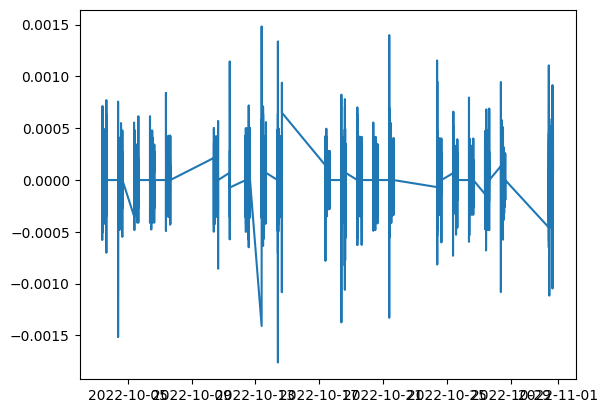

In [86]:
df = df.sort_index()
plt.plot(df)

In [87]:
second_data = df.values

Define objective functions

In [4]:
def obj(variables, data):
    data = np.array(data)
    mean = np.mean(data)
    var = np.var(data)
    sk = skew(data)
    kurt = kurtosis(data)

    c, g, m, y = variables
    c = 1.39
    var_theo = c * (m ** (y - 2) + g ** (y - 2)) * gamma(2 - y)

    eq1 = c * (m ** (y - 1) - g ** (y - 1)) * gamma(1 - y) - mean
    eq2 = var_theo - var
    eq3 = c * (m ** (y - 3) - g ** (y - 3)) * gamma(3 - y) / var_theo ** (3 / 2) - sk
    eq4 = c * (m ** (y - 4) + g ** (y - 4)) * gamma(4 - y) / var_theo**2 - kurt
    #eq3 = 0
    eq4 = 0
    return eq1**2 + eq2**2 + eq3**2 + eq4**2

In [205]:
def obj_c_fixed(variables, data, value):
    g, m, y = variables
    c = value
    sigma = 1e-5


    data = np.array(data)
    mean = np.mean(data)
    var = np.var(data)
    sk = skew(data)
    kurt = kurtosis(data)

    var_theo = c * (m ** (y - 2) + g ** (y - 2)) * gamma(2 - y) + sigma**2

    eq1 = c * (m ** (y - 1) - g ** (y - 1)) * gamma(1 - y) - mean
    eq2 = var_theo - var
    eq3 = c * (m ** (y - 3) - g ** (y - 3)) * gamma(3 - y) / var_theo ** (3 / 2) - sk
    #eq4 = (c * (m ** (y - 4) + g ** (y - 4)) * gamma(4 - y) )/ var_theo**2 - kurt
    #eq3 = 0
    eq4 = 0
    return eq1**2 + eq2**2 + eq3**2 + eq4**2

In [ ]:
def obj_y_fixed(variables, data, value):
    c, g, m = variables
    y = value

    data = np.array(data)
    mean = np.mean(data)
    var = np.var(data)
    sk = skew(data)
    kurt = kurtosis(data)

    var_theo = c * (m ** (y - 2) + g ** (y - 2)) * gamma(2 - y) 

    eq1 = c * (m ** (y - 1) - g ** (y - 1)) * gamma(1 - y) - mean
    eq2 = var_theo - var
    eq3 = c * (m ** (y - 3) - g ** (y - 3)) * gamma(3 - y) / var_theo ** (3 / 2) - sk
    #eq4 = c * (m ** (y - 4) + g ** (y - 4)) * gamma(4 - y) / var_theo**2 - kurt
    #eq3 = 0
    eq4 = 0
    return eq1**2 + eq2**2 + eq3**2 + eq4**2

In [68]:
best_val = np.inf
for i in range(100):
    c = np.random.uniform(0.0001, 100)
    g = np.random.uniform(0.0001, 100)
    m = np.random.uniform(0.0001, 100)
    y = np.random.uniform(0.001, 1.9)
    
    res = minimize(lambda x: obj_c_fixed(x, snp_rets, 0.204), [g, m, y], bounds=[(0.0001, 100), (0.0001, 100), (0.001, 1.9)])
    if res.fun < best_val:
        best_val = res.fun
        best_param = res.x
    print(i, best_val)
best_param

0 5.548178200990929e-05
1 3.937813101068069e-05
2 4.523340004489868e-06
3 4.523340004489868e-06
4 3.587340297103671e-07
5 3.587340297103671e-07
6 3.587340297103671e-07
7 3.587340297103671e-07
8 3.587340297103671e-07
9 3.587340297103671e-07
10 3.587340297103671e-07
11 1.0277075249601119e-07
12 1.0277075249601119e-07
13 1.0277075249601119e-07
14 1.0277075249601119e-07
15 1.0277075249601119e-07
16 1.0277075249601119e-07
17 1.0277075249601119e-07
18 1.0277075249601119e-07
19 1.0277075249601119e-07
20 1.0277075249601119e-07
21 1.0277075249601119e-07
22 1.0277075249601119e-07
23 1.0277075249601119e-07
24 1.0277075249601119e-07
25 1.0277075249601119e-07
26 1.0277075249601119e-07
27 1.0277075249601119e-07
28 1.0277075249601119e-07
29 1.0277075249601119e-07
30 1.0277075249601119e-07
31 1.0277075249601119e-07
32 1.0277075249601119e-07
33 1.0277075249601119e-07
34 1.0277075249601119e-07
35 1.0277075249601119e-07
36 1.0277075249601119e-07
37 1.0277075249601119e-07
38 1.0277075249601119e-07
39 1.02

array([5.10834359e+01, 4.20632423e+01, 1.00000000e-03])

In [53]:
best_val = np.inf
for i in range(100):
    c = np.random.uniform(0.0001, 100)
    g = np.random.uniform(0.0001, 100)
    m = np.random.uniform(0.0001, 100)
    y = np.random.uniform(0.001, 1.9)
    
    res = minimize(lambda x: obj_y_fixed(x, snp_rets, 0.0001), [c, g, m], bounds=[(0.0001, 100), (1, 100), (1, 1.9)])
    if res.fun < best_val:
        best_val = res.fun
        best_param = res.x
    print(i, best_val)
best_param

0 3.3366590061249815e-07
1 3.3366590061249815e-07
2 3.3366590061249815e-07
3 3.3366590061249815e-07
4 3.1959602778841987e-07
5 3.1415031358491237e-07
6 3.1415031358491237e-07
7 3.1415031358491237e-07
8 3.1415031358491237e-07
9 3.1415031358491237e-07
10 3.1415031358491237e-07
11 3.1415031358491237e-07
12 3.1415031358491237e-07
13 3.1415031358491237e-07
14 3.1415031358491237e-07
15 3.1415031358491237e-07
16 3.1415031358491237e-07
17 3.1415031358491237e-07
18 3.1415031358491237e-07
19 3.1415031358491237e-07
20 3.1415031358491237e-07
21 3.1415031358491237e-07
22 3.1415031358491237e-07
23 3.1415031358491237e-07
24 3.1415031358491237e-07
25 3.1415031358491237e-07
26 3.1415031358491237e-07
27 3.1415031358491237e-07
28 3.1415031358491237e-07
29 3.1415031358491237e-07
30 3.1415031358491237e-07
31 3.1415031358491237e-07
32 3.1415031358491237e-07
33 3.1415031358491237e-07
34 3.0362473670277814e-07
35 3.0362473670277814e-07
36 3.0362473670277814e-07
37 3.0362473670277814e-07
38 3.0362473670277814e

array([1.00000000e-04, 1.45663765e+00, 1.45711294e+00])

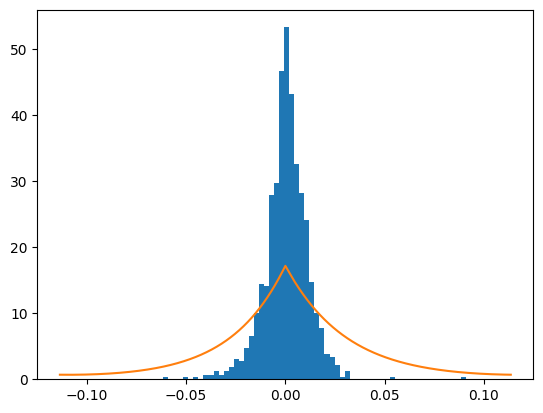

In [115]:
cgmy_gmm = CGMY(snp_rets, [1] + list([3.64561547e+01, 3.28523096e+01, 1.00000000e-03]) + [0.0]) 
x, pdf = cgmy_gmm.compute_pdf_from_cf()

plt.hist(snp_rets, density=True, bins=60, label="True returns")
plt.plot(x, pdf)

In [ ]:
best_val = np.inf
for i in range(100):
    c = np.random.uniform(0.0001, 100)
    g = np.random.uniform(0.0001, 100)
    m = np.random.uniform(0.0001, 100)
    y = np.random.uniform(0.001, 1.9)
    
    res = minimize(lambda x: obj(x, snp_rets), [c, g, m, y], bounds=[(0.0001, 100), (0.0001, 100), (0.0001, 100), (0.001, 1.9)])
    if res.fun < best_val:
        best_val = res.fun
        best_param = res.x
    print(i, best_val)
best_param

GMM on orderbook data

In [206]:
c = np.random.uniform(0.0001, 100)
g = np.random.uniform(0.0001, 100)
m = np.random.uniform(0.0001, 100)
y = np.random.uniform(0.001, 1.9)
res = minimize(
    lambda x: obj_c_fixed(x, second_data, 7.68400320e-01),
    [g, m, y],
    bounds=[(0.0001, 100), (0.0001, 100), (-5, 1.9)],
    method="Nelder-Mead"
)
res.x

array([99.99969694, 97.82092472, -0.36006792])

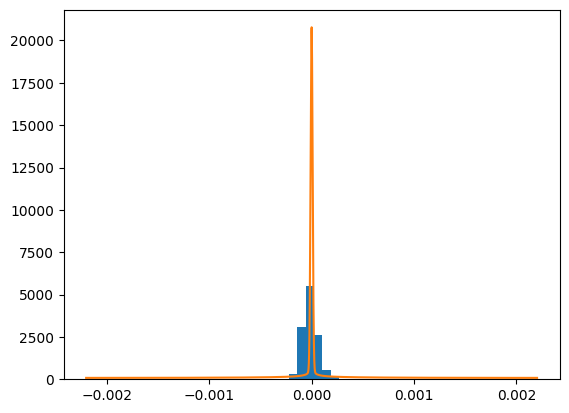

In [210]:
cgmy_gmm = CGMY(second_data, [ 7.68400320e-01, 99.99969694, 97.82092472, -0.36006792, 1e-05]) 
x, pdf = cgmy_gmm.compute_pdf_from_cf()

plt.hist(second_data, density=True, bins=40, label="True returns")
plt.plot(x, pdf)